### 종속변수 : 상권변화지표 - 행정동
생존한 사업체의 평균 영업기간이 길고 폐업한 사업체의 평균 영업기간이 짧은 동네를 성공 가능성이 높은 곳으로 라벨링하거나 해당 수치를 점수화하여 Y값으로 설정

<br/>

### 독립변수 : 나머지(추청매출, 점포, 길단위인구, 상주인구, 소득소비)

<br/>
<hr/>
<br/>

## 분석 로직 : 성공률 % 산출 방법
<br/>

1. 데이터 병합 : 행정동_코드를 기준으로 독립변수 합친 테이블 생성

2. 파생 변수 생성 :단순 숫자가 아닌 '인구 대비 점포 수', '점포당 평균 매출'과 같은 비율 데이터 생성

3. 모델링 (로지스틱 회귀분석) 사용
결과 출력: 사용자가 특정 동을 선택하면 모델이 계산한 확률값을 "이 지역의 창업 성공 확률은 78%입니다"라고 도출

<br/>
<br/>
<br/>



## 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 (파일 경로를 본인의 드라이브나 로컬 경로에 맞게 수정)
# 예: /content/drive/MyDrive/data/파일명.csv cp949
try:
    df_pop = pd.read_csv('/content/서울시 상권분석서비스(길단위인구-행정동).csv', encoding='utf-8')
    df_change = pd.read_csv('/content/서울시 상권분석서비스(상권변화지표-행정동).csv', encoding='utf-8')
    df_resident = pd.read_csv('/content/서울시 상권분석서비스(상주인구-행정동).csv', encoding='utf-8')
    df_income = pd.read_csv('/content/서울시 상권분석서비스(소득소비-행정동).csv', encoding='utf-8')
    df_store = pd.read_csv('/content/서울시 상권분석서비스(점포-행정동).csv', encoding='utf-8')
    df_sales = pd.read_csv('/content/서울시 상권분석서비스(추정매출-행정동).csv', encoding='utf-8')
except UnicodeDecodeError:
    # 한글 깨짐 방지를 위해 cp949 시도
    df_pop = pd.read_csv('/content/서울시 상권분석서비스(길단위인구-행정동).csv', encoding='cp949')
    df_change = pd.read_csv('/content/서울시 상권분석서비스(상권변화지표-행정동).csv', encoding='cp949')
    df_resident = pd.read_csv('/content/서울시 상권분석서비스(상주인구-행정동).csv', encoding='cp949')
    df_income = pd.read_csv('/content/서울시 상권분석서비스(소득소비-행정동).csv', encoding='cp949')
    df_store = pd.read_csv('/content/서울시 상권분석서비스(점포-행정동).csv', encoding='cp949')
    df_sales = pd.read_csv('/content/서울시 상권분석서비스(추정매출-행정동).csv', encoding='cp949')

# 2. 외식업종 코드 필터링 (CS100001 ~ CS100010)
food_codes = [f'CS1000{str(i).zfill(2)}' for i in range(1, 11)]

# 3. 데이터셋별 필요 컬럼 추출 및 정제
# [점포 - 독립변수용]
df_store_sub = df_store[df_store['서비스_업종_코드'].isin(food_codes)][[
    '기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
    '점포_수', '유사_업종_점포_수', '개업_율', '폐업_률'
]]

# [추정매출 - 독립변수용]
df_sales_sub = df_sales[df_sales['서비스_업종_코드'].isin(food_codes)][[
    '기준_년분기_코드', '행정동_코드', '서비스_업종_코드',
    '당월_매출_금액', '주중_매출_금액', '주말_매출_금액'
]]

# [상권변화지표 - 종속변수(Y) 후보]
# 서울 평균 지표는 동일 값이므로 제외
df_change_sub = df_change[[
    '기준_년분기_코드', '행정동_코드', '상권_변화_지표_명',
    '운영_영업_개월_평균', '폐업_영업_개월_평균'
]]

# [길단위인구 - 독립변수용]
df_pop_sub = df_pop[['기준_년분기_코드', '행정동_코드', '총_유동인구_수']]

# [상주인구 - 독립변수용]
df_resident_sub = df_resident[['기준_년분기_코드', '행정동_코드', '총_상주인구_수', '총_가구_수']]

# [소득소비 - 독립변수용]
df_income_sub = df_income[['기준_년분기_코드', '행정동_코드', '월_평균_소득_금액', '지출_총금액', '음식_지출_총금액']]

# 4. 데이터 결합 (Merge)
# 4-1. 업종별 정보가 있는 점포와 매출 데이터를 먼저 결합 (Inner Join)
merged_df = pd.merge(df_store_sub, df_sales_sub, on=['기준_년분기_코드', '행정동_코드', '서비스_업종_코드'], how='inner')

# 4-2. 행정동 단위의 나머지 데이터들을 차례로 결합 (Left Join)
common_keys = ['기준_년분기_코드', '행정동_코드']

merged_df = pd.merge(merged_df, df_change_sub, on=common_keys, how='left')
merged_df = pd.merge(merged_df, df_pop_sub, on=common_keys, how='left')
merged_df = pd.merge(merged_df, df_resident_sub, on=common_keys, how='left')
merged_df = pd.merge(merged_df, df_income_sub, on=common_keys, how='left')

#  ++ 행정동_코드 컬럼 삭제 (이름 컬럼이 있으므로)
if '행정동_코드' in merged_df.columns:
    merged_df = merged_df.drop(columns=['행정동_코드'])

# 5. 최종 데이터 확인 및 결측치 체크
print(f"최종 데이터 형태: {merged_df.shape}")
print(merged_df.isnull().sum())
print(merged_df)

# # 6. CSV 저장
# merged_df.to_csv('merged_final_data.csv', index=False, encoding='utf-8-sig')

최종 데이터 형태: (25803, 20)
기준_년분기_코드      0
행정동_코드_명       0
서비스_업종_코드      0
서비스_업종_코드_명    0
점포_수           0
유사_업종_점포_수     0
개업_율           0
폐업_률           0
당월_매출_금액       0
주중_매출_금액       0
주말_매출_금액       0
상권_변화_지표_명     0
운영_영업_개월_평균    0
폐업_영업_개월_평균    0
총_유동인구_수       0
총_상주인구_수       0
총_가구_수         0
월_평균_소득_금액     0
지출_총금액         0
음식_지출_총금액      0
dtype: int64
       기준_년분기_코드 행정동_코드_명 서비스_업종_코드 서비스_업종_코드_명  점포_수  유사_업종_점포_수  개업_율  폐업_률  \
0          20253     둔촌2동  CS100010       커피-음료    47          54     0     7   
1          20253     둔촌2동  CS100009     호프-간이주점    20          25     4     0   
2          20253     둔촌2동  CS100008       분식전문점    18          22     5     9   
3          20253     둔촌2동  CS100007       치킨전문점     5          12     8     0   
4          20253     둔촌2동  CS100006      패스트푸드점     5           7     0     0   
...          ...      ...       ...         ...   ...         ...   ...   ...   
25798      20241    청운효자동  CS100007       치킨전문점     2    

### 서울시 상권분석서비스에서 제공하는 **상권변화지표**
를 기준으로 ML 모델의 객관적 종속변수(Y값) 설정 기준

<hr/>

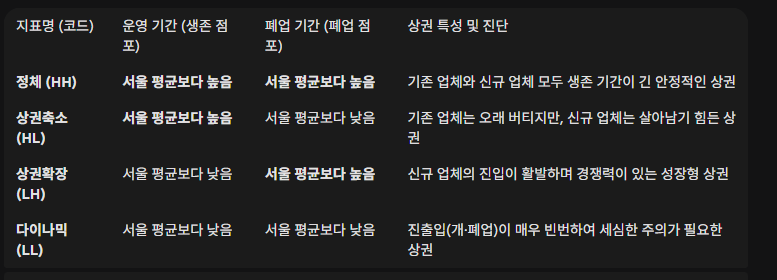

###

### y값 라벨링

In [ ]:
import pandas as pd

# 서울시 전체의 [분기별 + 업종별] 평균 데이터 계산 (비교 기준점 생성)
# 운영 영업 개월 평균과 폐업률의 서울시 기준치 생성
merged_df['서울_업종별_운영평균'] = merged_df.groupby(['기준_년분기_코드', '서비스_업종_코드_명'])['운영_영업_개월_평균'].transform('mean')
merged_df['서울_업종별_폐업평균'] = merged_df.groupby(['기준_년분기_코드', '서비스_업종_코드_명'])['폐업_률'].transform('mean')

# 복합 라벨링 함수 정의
def get_target_label(row):
    score = 0
    # 조건 1: 상권 지표가 긍정적인가? (정체 또는 상권확장)
    if row['상권_변화_지표_명'] in ['정체', '상권확장']:
        score += 1
    # 조건 2: 내 동네 생존 기간이 서울 평균보다 긴가?
    if row['운영_영업_개월_평균'] >= row['서울_업종별_운영평균']:
        score += 1
    # 조건 3: 내 동네 폐업률이 서울 평균보다 낮은가?
    if row['폐업_률'] <= row['서울_업종별_폐업평균']:
        score += 1
    # 3가지 중 2가지 이상 만족하면 성공(1), 아니면 실패(0)
    return 1 if score >= 2 else 0

# 데이터프레임에 적용하여 'target' 컬럼 생성
merged_df['target'] = merged_df.apply(get_target_label, axis=1)

# 결과 확인
print("--- 라벨링 결과 분포 ---") # 결과 : 0 - 13300, 1 - 12503
print(merged_df['target'].value_counts())
print("\n--- 성공 비율 ---") # 결과 : 0 - 0.515444, 1: 0.484556
print(merged_df['target'].value_counts(normalize=True))

# 제대로 들어갔는지 특정 동네(예: 둔촌2동) 확인
display(merged_df[merged_df['행정동_코드_명'] == '둔촌2동'][['서비스_업종_코드_명', '상권_변화_지표_명', '운영_영업_개월_평균', 'target']].head())

--- 라벨링 결과 분포 ---
target
0    13300
1    12503
Name: count, dtype: int64

--- 성공 비율 ---
target
0    0.515444
1    0.484556
Name: proportion, dtype: float64


,서비스_업종_코드_명,상권_변화_지표_명,운영_영업_개월_평균,target
0,커피-음료,상권축소,120,0
1,호프-간이주점,상권축소,120,1
2,분식전문점,상권축소,120,0
3,치킨전문점,상권축소,120,1
4,패스트푸드점,상권축소,120,1


### X값 추출 및 스케일링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 독립변수(X)로 사용할 수치형 컬럼들 정의
# 이미지에서 확인된 컬럼들과 상권 분석 핵심 지표들을 포함
features = [
    '점포_수', '유사_업종_점포_수', '개업_율', '폐업_률',
    '당월_매출_금액', '총_유동인구_수', '총_상주인구_수', '총_가구_수',
    '월_평균_소득_금액', '지출_총금액', '음식_지출_총금액',
    '운영_영업_개월_평균', '폐업_영업_개월_평균'
]

# 2. X(문제)와 y(정답) 분리
X = merged_df[features]
y = merged_df['target']

# 3. 데이터셋 분리 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. 스케일링 (StandardScaler 적용)
scaler = StandardScaler()

# 학습 데이터로 기준(평균, 표준편차)을 잡고 변환
X_train_scaled = scaler.fit_transform(X_train)

# 테스트 데이터는 학습 때 잡은 기준을 그대로 적용
X_test_scaled = scaler.transform(X_test)


print("--- 데이터 준비 완료 ---")
print(f"학습 데이터 개수: {len(X_train_scaled)}") # 20642개
print(f"테스트 데이터 개수: {len(X_test_scaled)}") # 5161개

--- 데이터 준비 완료 ---
학습 데이터 개수: 20642
테스트 데이터 개수: 5161


In [ ]:
# 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

### ML 모델 : 로지스틱 회귀 vs XGBoost 성능 비교

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:47:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== 모델별 정확도(Accuracy) 비교 ===
로지스틱 회귀 정확도: 0.8752
XGBoost 정확도      : 0.9789
----------------------------------------

[XGBoost 상세 성능 리포트]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2660
           1       0.98      0.98      0.98      2501

    accuracy                           0.98      5161
   macro avg       0.98      0.98      0.98      5161
weighted avg       0.98      0.98      0.98      5161



/tmp/ipython-input-2940990301.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


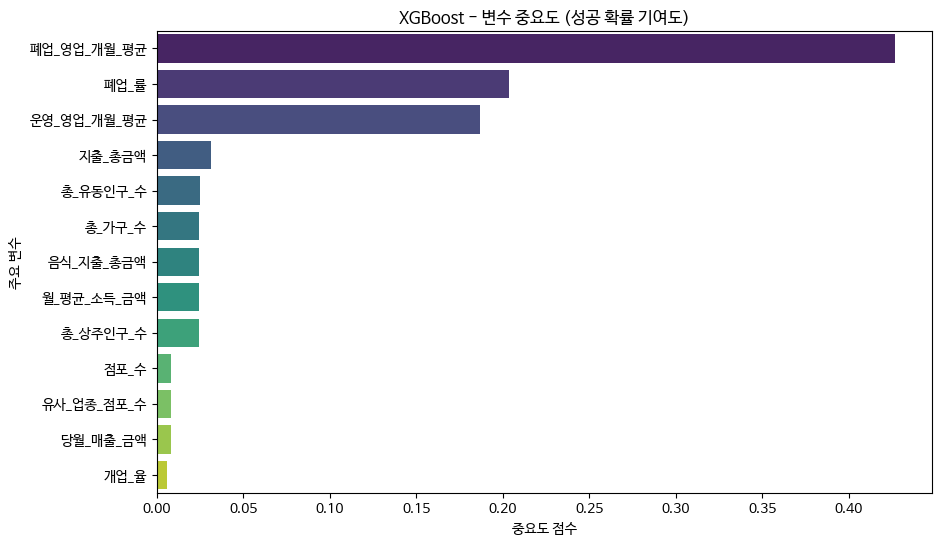

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 로지스틱 회귀 모델 학습 및 예측
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)

# 2. XGBoost 모델 학습 및 예측
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, xgb_pred)

# 3. 결과 출력
print("=== 모델별 정확도(Accuracy) 비교 ===")
print(f"로지스틱 회귀 정확도: {lr_acc:.4f}")
print(f"XGBoost 정확도      : {xgb_acc:.4f}")
print("-" * 40)

# 4. XGBoost 상세 리포트 (더 정밀한 모델 기준)
print("\n[XGBoost 상세 성능 리포트]")
print(classification_report(y_test, xgb_pred))

# 5. 변수 중요도 (Feature Importance) 시각화
# 어떤 변수가 성공/실패 판정에 가장 기여를 많이 했는지 확인
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(features)

sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('XGBoost - 변수 중요도 (성공 확률 기여도)')
plt.xlabel('중요도 점수')
plt.ylabel('주요 변수')
plt.show()

### 검증

In [ ]:
# 1. Y값 생성에 직접 쓰인 핵심 지표 제외 (데이터 유출 방지)
features_leaked = [
    '점포_수', '유사_업종_점포_수', '개업_율',
    '당월_매출_금액', '총_유동인구_수', '총_상주인구_수', '총_가구_수',
    '월_평균_소득_금액', '지출_총금액', '음식_지출_총금액'
    # '운영_영업_개월_평균', '폐업_률', '폐업_영업_개월_평균' 은 제외함
]

X_new = merged_df[features_leaked]
y_new = merged_df['target']

# 2. 데이터 분리 및 스케일링 재실행
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)
X_train_scaled_n = scaler.fit_transform(X_train_n)
X_test_scaled_n = scaler.transform(X_test_n)

# 3. XGBoost 재학습
xgb_model_n = XGBClassifier(random_state=42)
xgb_model_n.fit(X_train_scaled_n, y_train_n)

# 4. 성능 확인
new_acc = accuracy_score(y_test_n, xgb_model_n.predict(X_test_scaled_n))
print(f"핵심 지표 제외 후 정확도: {new_acc:.4f}")

핵심 지표 제외 후 정확도: 0.8675


### 변수 중요도 재확인 및 실전 예측 테스트

/tmp/ipython-input-3758387647.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_n[indices_n], y=feature_names_n[indices_n], palette='magma')


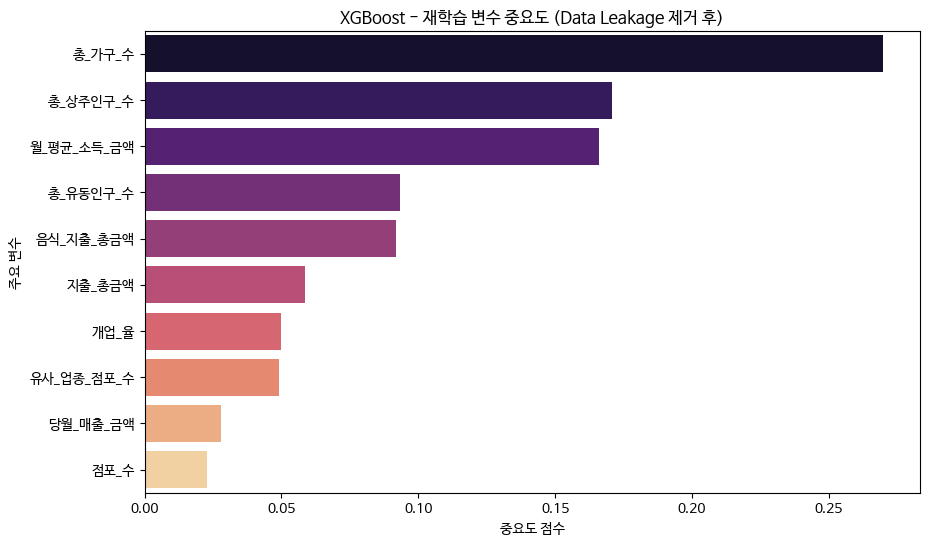

=== 창업 성공 확률 분석 결과 ===
예측 성공 확률: 92.69%
결과: 성공 예상


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1번: 변수 중요도 재확인 ---
plt.figure(figsize=(10, 6))
importances_n = xgb_model_n.feature_importances_
indices_n = np.argsort(importances_n)[::-1]
feature_names_n = np.array(features_leaked)

sns.barplot(x=importances_n[indices_n], y=feature_names_n[indices_n], palette='magma')
plt.title('XGBoost - 재학습 변수 중요도 (Data Leakage 제거 후)')
plt.xlabel('중요도 점수')
plt.ylabel('주요 변수')
plt.show()

# --- 2번: 실전 예측 테스트 함수 ---
def predict_success_priority(input_data):
    # 입력 데이터를 스케일링 (학습 때 사용한 scaler 기준)
    input_scaled = scaler.transform([input_data])

    # 성공 확률 계산
    prob = xgb_model_n.predict_proba(input_scaled)[0][1] # [실패확률, 성공확률] 중 성공확률 선택

    print(f"=== 창업 성공 확률 분석 결과 ===")
    print(f"예측 성공 확률: {prob*100:.2f}%")
    print(f"결과: {'성공 예상' if prob >= 0.5 else '주의 필요'}")
    print("================================")

# 테스트용 가상 데이터 (예: 둔촌2동 수치 기반)
# ['점포_수', '유사_업종_점포_수', '개업_율', '당월_매출_금액', '총_유동인구_수',
#  '총_상주인구_수', '총_가구_수', '월_평균_소득_금액', '지출_총금액', '음식_지출_총금액']
sample_data = [15, 10, 5.0, 500000000, 150000, 12000, 5000, 3500000, 1000000000, 400000000]
predict_success_priority(sample_data)

### 교차 검증 및 상세 리포트 확인

=== 5-Fold 교차 검증 결과 ===
회차별 정확도: [0.87067086 0.86437394 0.87112403 0.86991279 0.85489341]
평균 정확도  : 0.8662
표준 편차    : 0.0062
----------------------------------------

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2660
           1       0.84      0.90      0.87      2501

    accuracy                           0.87      5161
   macro avg       0.87      0.87      0.87      5161
weighted avg       0.87      0.87      0.87      5161



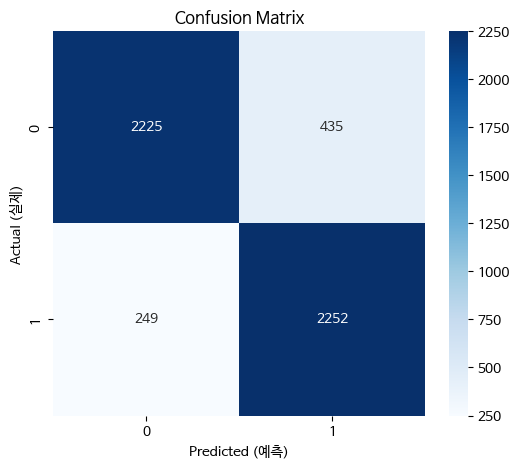

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# 교차 검증 실행 (5-Fold)
# 전체 데이터를 5등분해서 5번 시험
scores = cross_val_score(xgb_model_n, X_train_scaled_n, y_train_n, cv=5)

print(f"=== 5-Fold 교차 검증 결과 ===")
print(f"회차별 정확도: {scores}")
print(f"평균 정확도  : {scores.mean():.4f}")
print(f"표준 편차    : {scores.std():.4f}") # 이 값이 작을수록 모델이 안정적임
print("-" * 40)

# 혼동 행렬 및 상세 지표 확인
y_pred_n = xgb_model_n.predict(X_test_scaled_n)
print("\n[상세 분류 보고서]")
print(classification_report(y_test_n, y_pred_n))

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_n, y_pred_n), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted (예측)')
plt.ylabel('Actual (실제)')
plt.show()

### 모델과 스케일러 파일저장

In [ ]:
import joblib

# 1. 모델 저장
joblib.dump(xgb_model_n, 'xgb_model.pkl')

# 2. 스케일러 저장 (매우 중요!)
joblib.dump(scaler, 'scaler.pkl')


모델과 스케일러가 파일로 저장되었습니다.
